In [1]:
import numpy as np
import matplotlib.pyplot as pp
pp.rcParams.update({'font.size': 14})
pp.rcParams['figure.figsize'] = [10, 5]

In [2]:
def fc(b,x):
    y = 0*x
    for k in range(len(b)):
        y = y + b[k]*np.sin((k+1)*np.pi*x)
    return y

In [3]:
def b_one(N):
    b = []
    for k in range(1,N+1):
        if k % 2 == 1:
            b.append(4/k/np.pi)
        else:
            b.append(0)
    return b
def b_box(N):
    b = []
    s= 1
    for k in range(1,N+1):
        b.append( 0.2*(np.cos(k*np.pi/4)-np.cos(3*k*np.pi/4))/k*np.pi )
    return b
def b_tri(N):
    b = []
    s = 1
    for k in range(1,N+1):
        if k % 2 == 1:
            s = (-1)**((k-1)/2)
            b.append( 8/(np.pi*k)**2 *s )
        else:
            b.append(0)
    return b
def b_quad(N):
    b = []
    for k in range(1,N+1):
        if k % 2 == 1:
            s = (-1)**((k-1)/2)
            b.append( 8/(k*np.pi)**3)
        else:
            b.append(0)
    return b    

In [5]:
def plotfc(b):
    x = np.linspace(0,1,1000)
    y = fc(b,x)
    pp.plot(x,y)

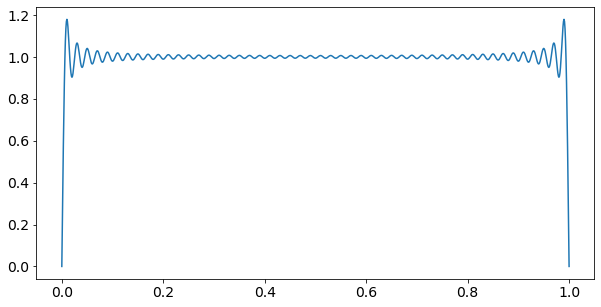

In [8]:
plotfc(b_one(100))

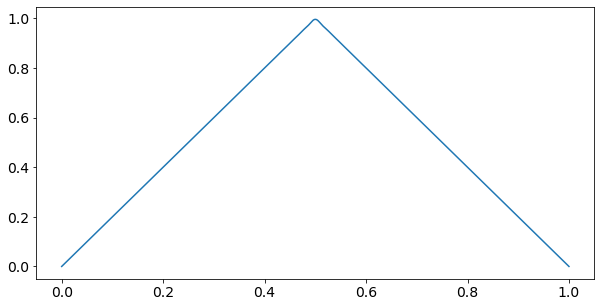

In [11]:
plotfc(b_tri(100))

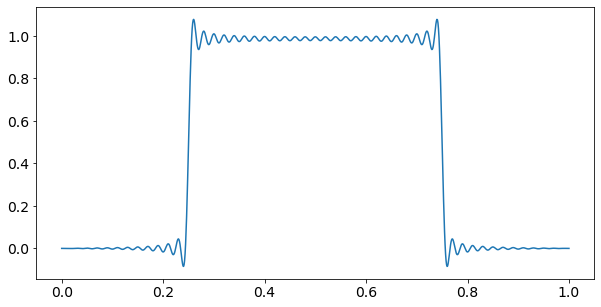

In [14]:
plotfc(b_box(100))

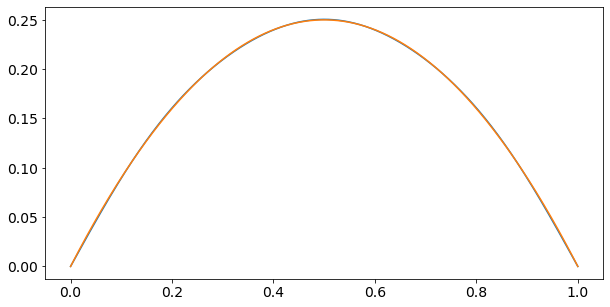

In [13]:
x = np.linspace(0,1,1000)
y = fc(b_box(5),x)
pp.plot(x,y,x,x*(1-x))


In [23]:
def heat_theta(u0,T,M,N,theta,kappa=1.0):
    from scipy import sparse
    from scipy.linalg import solve_banded
    import numpy as np
    
    h = 1/(N+1)
    k = T/M
    
    x = np.linspace(0,1,N+2)
    x_int = x[1:N+1]
    t = np.linspace(0,T,M+1)
    
    lam = k/h/h
    Ad = np.zeros((3,N))
    Ad[0,:] = kappa*theta*lam
    Ad[1,:] = 1-2*kappa*theta*lam
    Ad[2,:] = theta*kappa*lam

    Bd = np.zeros((3,N))
    Bd[0,:] = -(1-theta)*kappa*lam
    Bd[1,:] = 1+2*(1-theta)*kappa*lam
    Bd[2,:] = -(1-theta)*kappa*lam

    A = sparse.spdiags(Ad,(-1,0,1),N,N)

    ucurr = u0(x_int)    
    u = np.zeros((N+2,M+1))
    u[1:N+1,0] = ucurr
    
    for j in range(1,M+1):
        rhs = A.dot(ucurr)
        ucurr = solve_banded((1,1),Bd,rhs)
        u[1:N+1 ,j] = ucurr

    return (x,t,u)

In [24]:
def u0(x):
    return 1.0*(np.abs(x-0.5) < 0.25)

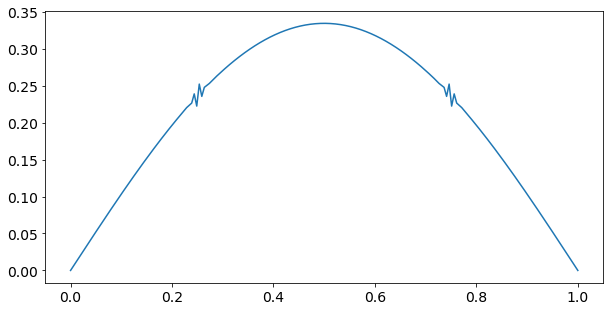

In [45]:
(x,t,u) = heat_theta(u0, T=0.1, M=100, N=200, theta=0.5)
pp.plot(x,u[:,-1])

In [ ]:
def linfit(h,err):
    print( err )
    logh = np.log10(h);
    loge = np.log10(err);
    (p,logC) = np.polyfit(logh,loge,deg=1)
    return (10**logC,p)

def convplot(h,*args):
    fits = []
    for y in args:
        fits.append(linfit(h,y[0]))
    
    import matplotlib.pyplot as pp
    for (k,y) in enumerate(args):
        C,p = fits[k]
        pp.loglog(h,y[0],y[1],label="$O(%s^{%f})$" % (y[2],p))        
        pp.loglog(h,C*(h**p))

In [406]:
h_list=np.array([0.05, 0.02, 0.01, 0.005, 0.002, 0.001])
T=0.1
kappa=1/20
J=5
u_exact = lambda x,t: np.exp(-kappa*(J*np.pi)**2*t)*np.sin(J*np.pi*x)

def heat_error(theta):
    err = []
    for h in h_list:
        N = int(1/h)
        k = 2*h
        M = int(T/k)
        (x,t,u)=heat_theta(lambda x: np.sin(J*np.pi*x),T=T,M=M,N=N,theta=theta,kappa=kappa)
        xx, tt = np.meshgrid(x,t,indexing='ij')
        err.append( np.max(np.abs(u_exact(x,0.1)-u[:,-1])) )
        #err.append( np.max(np.abs(u_exact(xx,tt)-u)) )
    return err;

[0.16761389916750263, 0.0935786693969538, 0.04143092132125503, 0.02140461847093117, 0.008739961889396575, 0.004400836181474521]


Text(0.5, 1.0, 'Backwards Euler')

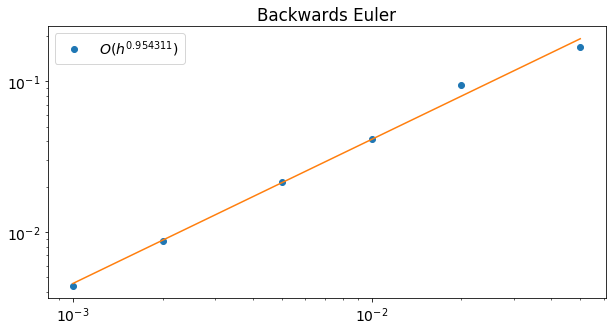

In [407]:
err = heat_error(theta=0.0)
convplot(h_list,(err,'o','h'))
pp.legend()
pp.title("Backwards Euler")

[0.0321689110520883, 0.008822945448453245, 0.001102577077761957, 0.0002730781105307889, 4.34839109956231e-05, 1.0855101757079044e-05]


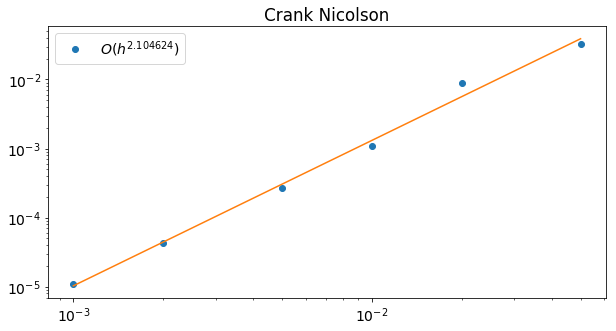

In [408]:
err = heat_error(theta=0.5);
convplot(h_list,(err,'o','h'));
pp.legend();
pp.title("Crank Nicolson");

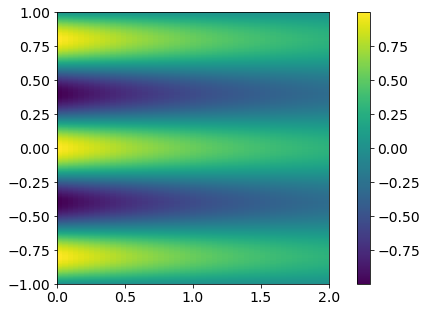

In [412]:
pp.imshow(u,extent=[0,2,-1,1])
pp.colorbar()

(1002,)

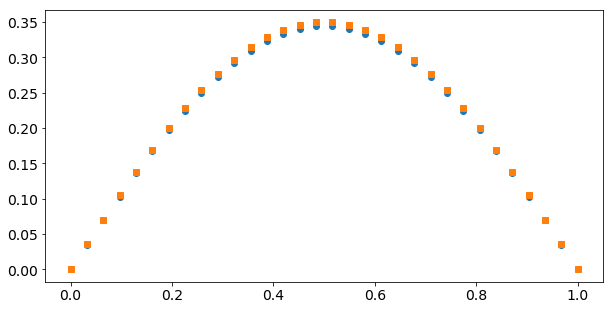

In [457]:
M=30
T=0.1
N=30
(x,t,u_cn)=heat_theta(u0,T,M,N,theta=1/2)
(x,t,u_be)=heat_theta(u0,T,M,N,theta=0)
j=-1
pp.plot(x,u_cn[:,j],'o',x,u_be[:,j],'s')